### Load word embeddings
- We are using GloVe (Global Vectors for Word Representation) in order to obtain vector representations of our word embeddings
- GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [1]:
from torchtext.vocab import GloVe

# Load pre-trained Word2Vec embeddings(GloVe)
word_embeddings = GloVe(name='6B', dim=100)

### Load raw dataset
-  Since the dataset we sourced from NACC is not publicly available, we write in a local perspective so in order to run the code, you need to gain access to dataset and install it to your local machine and later on you may configure the local paths defined below

In [ ]:
import sys
sys.path.append('../')  # Add the parent folder to the system path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from artificial_nn import ANN
import util.preprocess as preprocess

# use below line for local use
# extracted_df = pd.read_csv("./nacc_processed.csv").astype("float")


# use below lines assuming you only have raw data (not filtered one)

data = pd.read_csv("../../nacc/newer/investigator_ftldlbd_nacc65.csv")

### Extract columns from raw data and adjust the visit date
- We try to apply forward and backward (if forward imputation still results in missing value for patients) imputation for each patient that has more than 1 visit
- So we modified the dataset accordingly where we sort the data w.r.t. patient id and visit date

In [3]:
data['VISITDAY'] = data['VISITDAY'].astype(str).str.zfill(2)
data['VISITMO'] = data['VISITMO'].astype(str).str.zfill(2)
data['VISITYR'] = data['VISITYR'].astype(str)
data['VISITDT'] = data['VISITYR'] + data['VISITMO'] + data['VISITDAY']

columns_to_use = ['NACCID', 'VISITDT','NACCMOCA','CRAFTDRE','COMMUN','NACCMMSE','HOMEHOBB','JUDGMENT','LOGIMEM','CDRSUM','MEMORY', 'BOSTON', 'MINTTOTS', 'ANIMALS', 'MEMUNITS', 'TRAILB', 'NACCUDSD']
extracted_df = data[columns_to_use]
extracted_df = extracted_df.sort_values(by=["NACCID", "VISITDT"], ascending=True)
new_csv = './nacc_processed.csv'
# write the DataFrame to a CSV file
extracted_df.to_csv(new_csv, index=False)

### Data Preprocessing (#1)
- Forward and Backward Filling for Missing Values (Data Imputation)

In [4]:
features_to_impute = columns_to_use[2:-1]

def forward_and_backward_impute(group):
    for feature in features_to_impute:
        if feature == "NACCMOCA" or feature == "NACCMMSE":
            group[feature] = group[feature].replace([-4,88,99], pd.NA)
        else:
            # replace -4 and 99 with nan for processing
            group[feature] = group[feature].replace([-4,99], pd.NA)
        # forward fill nan values
        group[feature] = group[feature].ffill()
        # backward fill nan values
        group[feature] = group[feature].bfill()
    return group

# Group by patient_id and apply forward and backward impute function
extracted_df = extracted_df.groupby('NACCID').apply(forward_and_backward_impute)

for feature in features_to_impute:
    extracted_df[feature] = extracted_df[feature].fillna(-4)

new_csv = './fb_imputed.csv'
# write the DataFrame to a CSV file
extracted_df.to_csv(new_csv, index=False)

### Data Preprocessing (#2)
- Create binary indicators for severity values (e.g. 95,...,99)

In [5]:
severity_value_pairs  = {
    "CRAFTDRE" : [95,96,97,98],
    "LOGIMEM" : [95,96,97,98],
    "NACCMMSE" : [95,96,97,98],
    "BOSTON" : [95,96,97,98],
    "MINTTOTS" : [95,96,97,98],
    "ANIMALS" : [95,96,97,98],
    "MEMUNITS" : [95,96,97,98],
    "TRAILB" : [995,996,997,998],
}

include_severity_vals = list(severity_value_pairs.keys())

# create a seperate column for severity cases - binary indicator
for col in include_severity_vals:
    for val in severity_value_pairs[col]:
        extracted_df[f"{col}_{val}"] = (extracted_df[col] == val).astype(int)

# replace all severity values with NaN - ensure gloablity, easier to compare
for col, severity_values in severity_value_pairs.items():
    extracted_df[col] = extracted_df[col].replace(severity_values, np.nan)

# imputation values is a dictionary that contains mean values of columns with each label
# keys : column names , values : list with 4 (number of labels) values
imputation_values = {}

for col in severity_value_pairs.keys():
    means = []
    for label in range(1,5):
        means.append(extracted_df[extracted_df["NACCUDSD"] == label][col].mean())
    imputation_values[col] = means

# replace each missing value with its imputation values
for index, row in extracted_df.iterrows():
    for col in severity_value_pairs.keys():
        if np.isnan(row[col]):
            label = row["NACCUDSD"]
            imputation_val = imputation_values[col][label - 1]
            extracted_df.at[index, col] = imputation_val

main_df = extracted_df

preprocess.put_the_column_at_end(main_df, "NACCUDSD")

NACCID   VISITDT  NACCMOCA   CRAFTDRE  COMMUN  \
NACCID                                                                 
NACC000011 31511   NACC000011  20060417        -4  -4.000000     0.0   
           31512   NACC000011  20070618        -4  -4.000000     0.0   
           31513   NACC000011  20080603        -4  -4.000000     0.0   
           31514   NACC000011  20090803        -4  -4.000000     0.0   
NACC000034 183244  NACC000034  20150716        27  16.000000     0.0   
...                       ...       ...       ...        ...     ...   
NACC999872 158296  NACC999872  20230321        20   9.610241     0.0   
NACC999922 57864   NACC999922  20120807        -4  -4.000000     0.0   
           57865   NACC999922  20130806        -4  -4.000000     0.0   
NACC999954 85160   NACC999954  20060327        -4  -4.000000     0.5   
NACC999969 57866   NACC999969  20091102        -4  -4.000000     0.0   

                   NACCMMSE  HOMEHOBB  JUDGMENT    LOGIMEM  CDRSUM  ...  \
NACCID                                                              ...   
NACC000011 31511       30.0       0.0       0.0  12.000000     0.5  ...   
           31512       29.0       0.0       0.0  13.000000     0.5  ...   
           31513       30.0       0.0       0.0  12.000000     0.5  ...   
           31514       28.0       0.0       0.0  11.000000     0.5  ...   
NACC000034 183244      -4.0       0.0       0.0  -4.000000     0.5  ...   
...                     ...       ...       ...        ...     ...  ...   
NACC999872 158296      29.0       0.0       0.0   9.913696     0.0  ...   
NACC999922 57864       30.0       0.0       0.0  19.000000     0.0  ...   
           57865       30.0       0.0       0.0  12.000000     0.0  ...   
NACC999954 85160       23.0       0.5       1.0   4.000000     4.0  ...   
NACC999969 57866       30.0       0.0       0.0  16.000000     0.0  ...   

                   ANIMALS_98  MEMUNITS_95  MEMUNITS_96  MEMUNITS_97  \
NACCID                                                                 
NACC000011 31511            0            0            0            0   
           31512            0            0            0            0   
           31513            0            0            0            0   
           31514            0            0            0            0   
NACC000034 183244           0            0            0            0   
...                       ...          ...          ...          ...   
NACC999872 158296           0            0            0            1   
NACC999922 57864            0            0            0            0   
           57865            0            0            0            0   
NACC999954 85160            0            0            0            0   
NACC999969 57866            0            0            0            0   

                   MEMUNITS_98  TRAILB_995  TRAILB_996  TRAILB_997  \
NACCID                                                               
NACC000011 31511             0           0           0           0   
           31512             0           0           0           0   
           31513             0           0           0           0   
           31514             0           0           0           0   
NACC000034 183244            0           0           0           0   
...                        ...         ...         ...         ...   
NACC999872 158296            0           0           0           1   
NACC999922 57864             0           0           0           0   
           57865             0           0           0           0   
NACC999954 85160             0           0           0           0   
NACC999969 57866             0           0           0           0   

                   TRAILB_998  NACCUDSD  
NACCID                                   
NACC000011 31511            0         3  
           31512            0         3  
           31513            0         3  
           31514            0         2  
NACC000034

### Missing Value Analysis
- We try to reduce the number of patients with missing value
- Can modify number of features in this stage (e.g. remove the feature with so many missing values)
- Removal of duplicates occured from data imputation in order not to introduce bias (e.g. identical row for same patient)

In [6]:
# handle missing values
missing_value_pairs  = {
    "NACCMOCA" : [-4,88,99],
    "CRAFTDRE" : [-4],
    "LOGIMEM" : [-4],
    "NACCMMSE" : [-4,88],
    "CDRSUM" : [99],
    "BOSTON" : [-4],
    "MINTTOTS" : [-4],
    "ANIMALS" : [-4],
    "MEMUNITS" : [-4],
    "TRAILB" : [-4],
}

# replace all missing values with NaN - ensure gloablity, easier to compare
for col, missing_values in missing_value_pairs.items():
    main_df[col] = main_df[col].replace(missing_values, np.nan)

# imputation values is a dictionary that contains mean values of columns with each label
# keys : column names , values : list with 4 (number of labels) values
imputation_values = {}

for col in missing_value_pairs.keys():
    means = []
    for label in range(1,5):
        means.append(main_df[main_df["NACCUDSD"] == label][col].mean())
    imputation_values[col] = means

# replace each missing value with its imputation values
for index, row in main_df.iterrows():
    for col in missing_value_pairs.keys():
        if np.isnan(row[col]):
            label = row["NACCUDSD"]
            imputation_val = imputation_values[col][label - 1]
            main_df.at[index, col] = imputation_val


# due to backward and forward filling there might be few duplicate rows for the same patient
# in order to avoid bias we can remove the duplicate rows of the patient
columns_to_look_for = main_df.columns.difference(["VISITDT"])
prev = main_df.shape[0]
main_df = main_df.drop_duplicates(subset=columns_to_look_for, keep='first')
post = main_df.shape[0]
print(f"{prev-post} duplicate rows are found and removed")
# below lines can be used to visualize new matrix - ensure everything is going okay basically
#new_csv = './visualize_main_df.csv'
#main_df.to_csv(new_csv, index=False)

8415 duplicate rows are found and removed


### Class Imbalance
- Removing class imbalance using random undersampling

Original class distribution: Counter({1: 86302, 4: 53384, 3: 32411, 2: 8188})
Class distribution after random undersampling: Counter({1: 8188, 2: 8188, 3: 8188, 4: 8188})


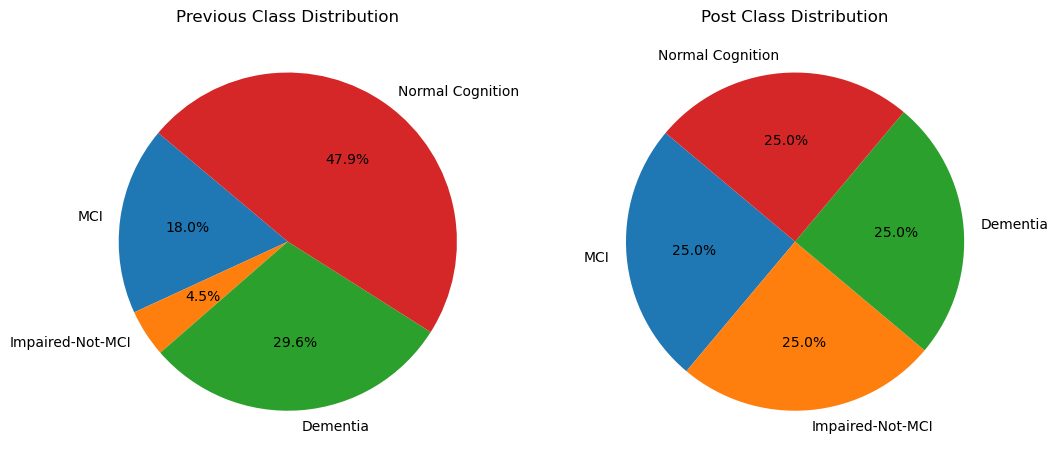

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X, y = preprocess.sep_column(main_df, "NACCUDSD")
dic_y = Counter(y)
print(f"Original class distribution: {dic_y}")
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)
dic_y_resampled = Counter(y_resampled)
print(f"Class distribution after random undersampling: {dic_y_resampled}")

main_df = pd.concat([X_resampled, y_resampled], axis=1)
#new_csv = './undersampled_df.csv'
#main_df.to_csv(new_csv, index=False)

previous_distribution = {}
post_distribution = {}

for key in dic_y.keys():
    if key == 1:
        previous_distribution["Normal Cognition"] = dic_y[key]
        post_distribution["Normal Cognition"] = dic_y_resampled[key]
        pass
    elif key == 2:
        previous_distribution["Impaired-Not-MCI"] = dic_y[key]
        post_distribution["Impaired-Not-MCI"] = dic_y_resampled[key]
    elif key == 3:
        previous_distribution["MCI"] = dic_y[key]
        post_distribution["MCI"] = dic_y_resampled[key]
    else:
        previous_distribution["Dementia"] = dic_y[key]
        post_distribution["Dementia"] = dic_y_resampled[key]

# create subplots for the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# pie chart for previous distribution
ax1.pie(previous_distribution.values(), labels=previous_distribution.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Previous Class Distribution')

# pie chart for post distribution
ax2.pie(post_distribution.values(), labels=post_distribution.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Post Class Distribution')
plt.show()

### Application of word embedding and NN training
- We replace the values of the features where word embedding is appicable to use
- We've already defined our ANN class hence, we can directly use it here for training

In [ ]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# shape the dataset before feeding to NN
main_df = main_df.drop(["NACCID","VISITDT"], axis=1)

suitable_word_embedded_columns = ["COMMUN", "HOMEHOBB", "JUDGMENT", "MEMORY"]

# delete the rows with 99 in it (missing value)
main_df = main_df[~main_df[suitable_word_embedded_columns].eq(99).any(axis=1)]

column_combinations = [[]]

# generate all combinations of different word embeddings
for r in range(1, len(suitable_word_embedded_columns) + 1):
    for combination in itertools.combinations(suitable_word_embedded_columns, r):
        column_combinations.append(list(combination))

string_mapping = {
    0.0: 'no symptom',
    0.5: 'uncertain symptom',
    1.0: 'mild symptom',
    2.0: 'moderate symptom',
    3.0: 'severe symptom',
}

for word_embedded_columns in column_combinations:
    
    dataframe = main_df.copy(deep = True)

    for col in word_embedded_columns:
        dataframe[col] = dataframe[col].map(string_mapping)

    # Features : X , Labels : y
    X, y = preprocess.sep_column(dataframe, "NACCUDSD")
    y = y.astype(int)
    
    print(y.unique())

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=462)

    # adjustment for pytorch nn training 
    """
    The targets should be in the range [0, 3] for our use case, as they are used to index the output tensor
    """
    y_train = y_train - 1
    y_test = y_test - 1


    X_train = preprocess.replace_with_word_embeddings(X_train, word_embeddings, word_embedded_columns)
    X_test = preprocess.replace_with_word_embeddings(X_test, word_embeddings, word_embedded_columns)
        
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
    X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values)
    y_test_tensor = torch.tensor(y_test.values)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    input_size = X_train_tensor.shape[1]
    hidden_sizes = [512,256,128,64]               # hidden layer size is hyperparameter
    output_size = len(y.unique())
    
    model = ANN.ArtificialNeuralNetwork(input_size, hidden_sizes, output_size)
    
    criterion = nn.CrossEntropyLoss()                       # cross entropy value is used as loss function
    optimizer = optim.Adam(model.parameters(), lr=0.0001)    # learning rate is hyperparameter
    
    num_epochs = 500
    loss_list = []
    
    for epoch in range(num_epochs):
        loss_of_epoch = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()               # clears the gradients before new back prop (new batch)
            outputs = model.forward(inputs)     # feed model with forward prop (get predictions - outputs)
            loss = criterion(outputs, labels)   # calculate loss value of predictions
            loss.backward()                     # perform back prop to compute gradient w.r.t model params
            optimizer.step()                    # update the model params (weights) according to LR and gradient

            loss_of_epoch += loss.item()

        loss_list.append(loss_of_epoch / len(train_loader))
    
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    plt.plot(range(1, num_epochs + 1), loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve for replacing {" , ".join(word_embedded_columns)} attribute with word embedding vector')
    plt.legend()
    plt.show()
    
    # evaluation of model in test set
    with torch.no_grad():
        model.eval()
        outputs = model.forward(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print("\nClassification Report:")
    print(classification_report(y_test_tensor.cpu(), predicted.cpu(), digits=4))